The business partner has two primary objectives to get from this analysis:
1.	Obtain a model that will estimate shipping cost (column “Cost”) for new selections of input variables.  Assume we could change route class and priority if desired.  The data provided includes all possible shipment origins but not all future shipment destinations as we regularly get new customers.
2.	Determine if there are any outliers in the historical data suggesting a higher-than-expected shipping cost that would warrant a follow-up with transportation suppliers regarding their rates.
 
Create a model of cost that you feel captures most of the signal present in the dataset and rejects most of the noise.  See below on how to obtain the data.  As a check, the dataset should be comprised of 306 rows and 8 columns.  

<b>Notebook has following sections:<b>

1- Data understanding and exploration 

2- Data cleaning

3- Data preparation: Feature Engineering and Scaling

4- Feature Selection using RFE and Model Building  

5- Linear Regression Assumptions Validation and Outlier Removal

6- Rebuilding the Model Post Outlier Removal: Feature Selection using K-Fold Cross Validation & RFE  

7- Removing Multicollinearity, Model Re-evaluation and Assumptions Validation 

In [775]:
#Importing requried packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn import preprocessing

In [776]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/bmewing/technical_assessment/master/data.csv")
df.head()

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49


In [777]:
df.shape

(306, 8)

In [778]:
df.dtypes

Origin City           object
Origin State          object
Destination City      object
Destination State     object
Route Class           object
Priority               int64
Distance               int64
Cost                 float64
dtype: object

In [779]:
df.describe()

,Priority,Distance,Cost
count,306.000000,306.000000,306.000000
mean,1.196078,960.526144,3226.464771
std,0.715714,639.685113,1429.989144
min,1.000000,9.000000,683.620000
25%,1.000000,452.250000,2169.320000
50%,1.000000,835.000000,3004.175000
75%,1.000000,1264.750000,3938.597500
max,10.000000,3247.000000,8265.170000


## Missing Values

In [780]:
df.isnull().values.any()

False

In [781]:
df.isnull().sum()
## No missing values in the dataset

Origin City          0
Origin State         0
Destination City     0
Destination State    0
Route Class          0
Priority             0
Distance             0
Cost                 0
dtype: int64

In [782]:
(df.select_dtypes(include=['int64'])).columns

Index(['Priority', 'Distance'], dtype='object')

## EDA

## Numerical variables

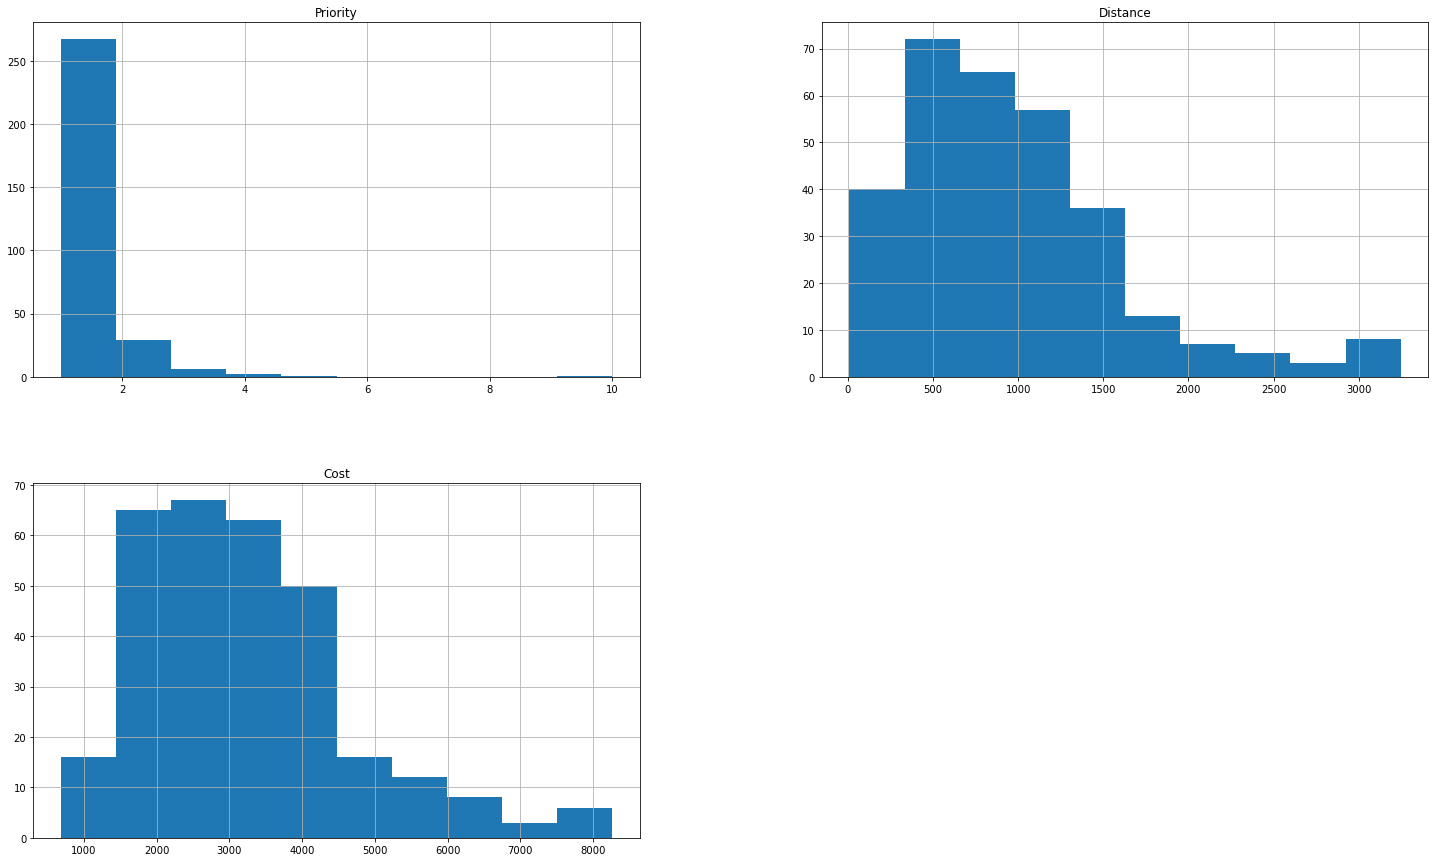

In [783]:
#Exploring histograms of numerical columns 
df.hist(bins=10, figsize=(25,15))
plt.show()

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


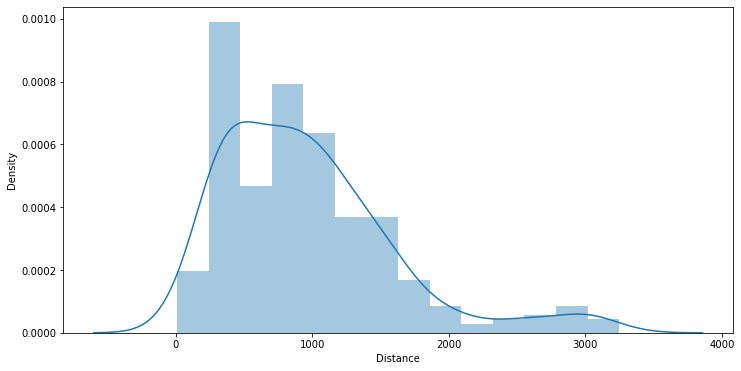

In [784]:
# Distance: distance travalled by ship from to Origin to Destination
sns.distplot(df['Distance'])
plt.show()

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


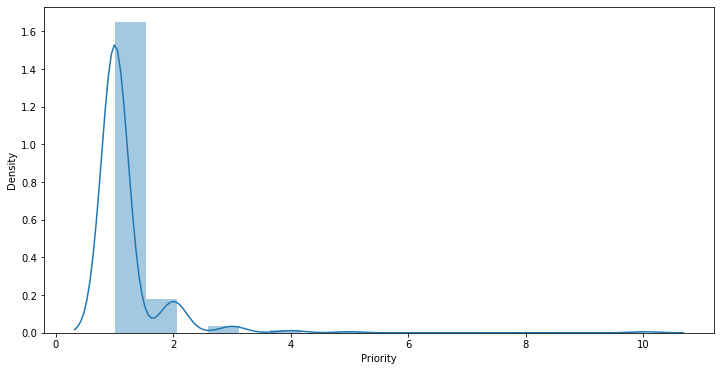

In [785]:
sns.distplot(df['Priority'])
plt.show()

In [786]:
df['Priority'].value_counts()

1     267
2      29
3       6
4       2
10      1
5       1
Name: Priority, dtype: int64

In [787]:
#it is good to change Priority column from int to object?
df['Priority']=df['Priority'].astype('object')

In [788]:
df.dtypes

Origin City           object
Origin State          object
Destination City      object
Destination State     object
Route Class           object
Priority              object
Distance               int64
Cost                 float64
dtype: object

In [789]:
#creating df  with numeric var's only
df_numeric=df.select_dtypes(include=['float64','int64'])
df_numeric.head()

,Distance,Cost
0,808,3105.12
1,779,3357.28
2,657,2670.23
3,610,2715.14
4,235,2241.49


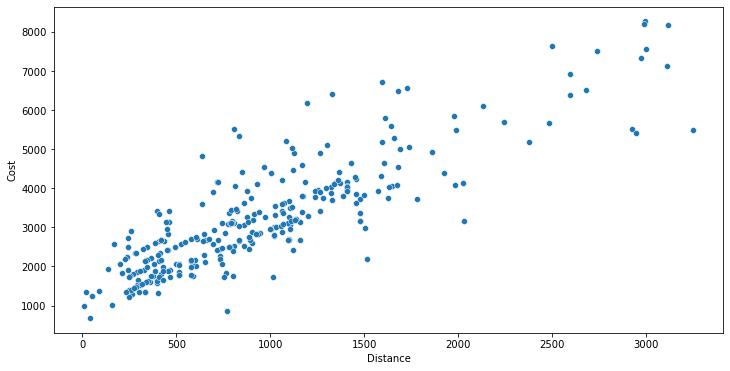

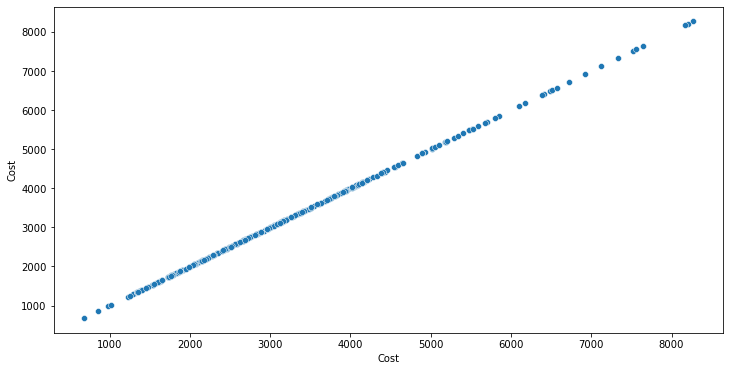

In [790]:
#LINEARITY CHECK>>>#to check price has linear relation or not with Indep. var's

for i, col in enumerate (df_numeric.columns):
    plt.figure(i)
    sns.scatterplot(x=df_numeric[col],y=df_numeric['Cost'])

## Target Variable- Cost

In [791]:
df.describe()

,Distance,Cost
count,306.000000,306.000000
mean,960.526144,3226.464771
std,639.685113,1429.989144
min,9.000000,683.620000
25%,452.250000,2169.320000
50%,835.000000,3004.175000
75%,1264.750000,3938.597500
max,3247.000000,8265.170000


C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


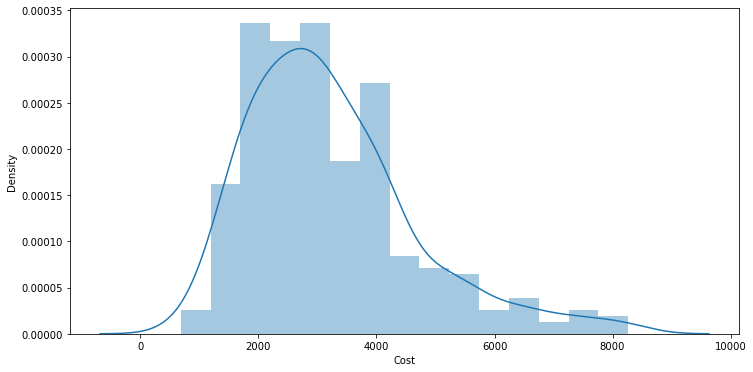

In [792]:
sns.distplot(df['Cost'])
plt.show()

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density or Relative Frequency Of Ships By Price')

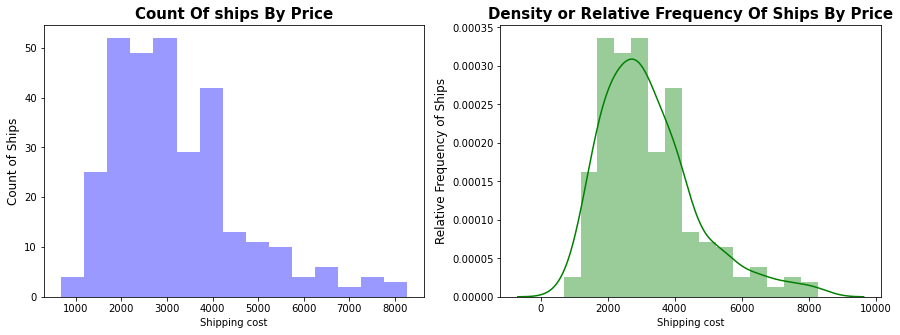

In [793]:
# target variable: Cost of ship

fig, ax= plt.subplots(1,2,figsize=(15,5))

sns.distplot(df['Cost'], norm_hist=False, kde=False, ax=ax[0], color='blue')
ax[0].set_xlabel('Shipping cost')
ax[0].set_ylabel('Count of Ships',size=12)
ax[0].set_title('Count Of ships By Price',size=15,weight="bold")

sns.distplot(df['Cost'], kde=True, ax=ax[1], color='green')
ax[1].set_xlabel('Shipping cost')
ax[1].set_ylabel('Relative Frequency of Ships',size=12)
ax[1].set_title('Density or Relative Frequency Of Ships By Price',size=15,weight="bold")

# Observations on Target Variable- Cost:
    
1. The target variable price has a positive skew, however majority of the cars are low priced.


2. More than 50% of the Ships (around 150 out of total of 306) are priced 2,200  to 4,000 and 
   close to 25% cars are priced between 3000 and 4,000. 
   So around 80% of ships are priced between 1,500 to 6000. 


<b> 

- Distance variable appears to have a linear relation with Cost
    
- Priority don't have a relation with price or relationship isn't strong. None of the varibales appear to have polynomial relation with price.

- In linear regression assumptions validation section we will check for linearity assumption in detail 

## Correlation Matrix

In [794]:
df.corr()

,Distance,Cost
Distance,1.00000,0.86083
Cost,0.86083,1.00000


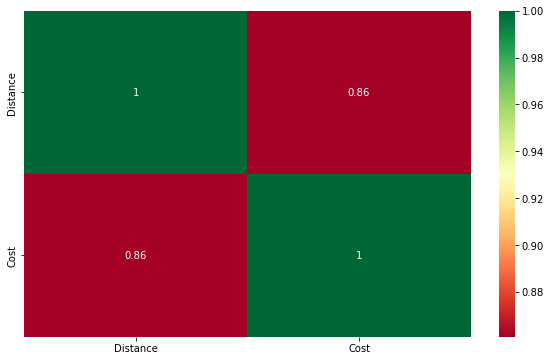

In [795]:

import seaborn as sns
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,6))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Useful insights from Corr Heatmap


 1. <b> Dependent var and indep. var's<b>

> Positive corr: 'Cost' highly correlated with 'Distance'
    
2. <b> Correlation among independent variables:<b>

> 'Cost' has very low correlation with 'Priority'

We'll cross check and pay attention to multicollinearity in assumptions validation section using VIF score.

In [796]:
df.head()

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49


##  Categorical Data

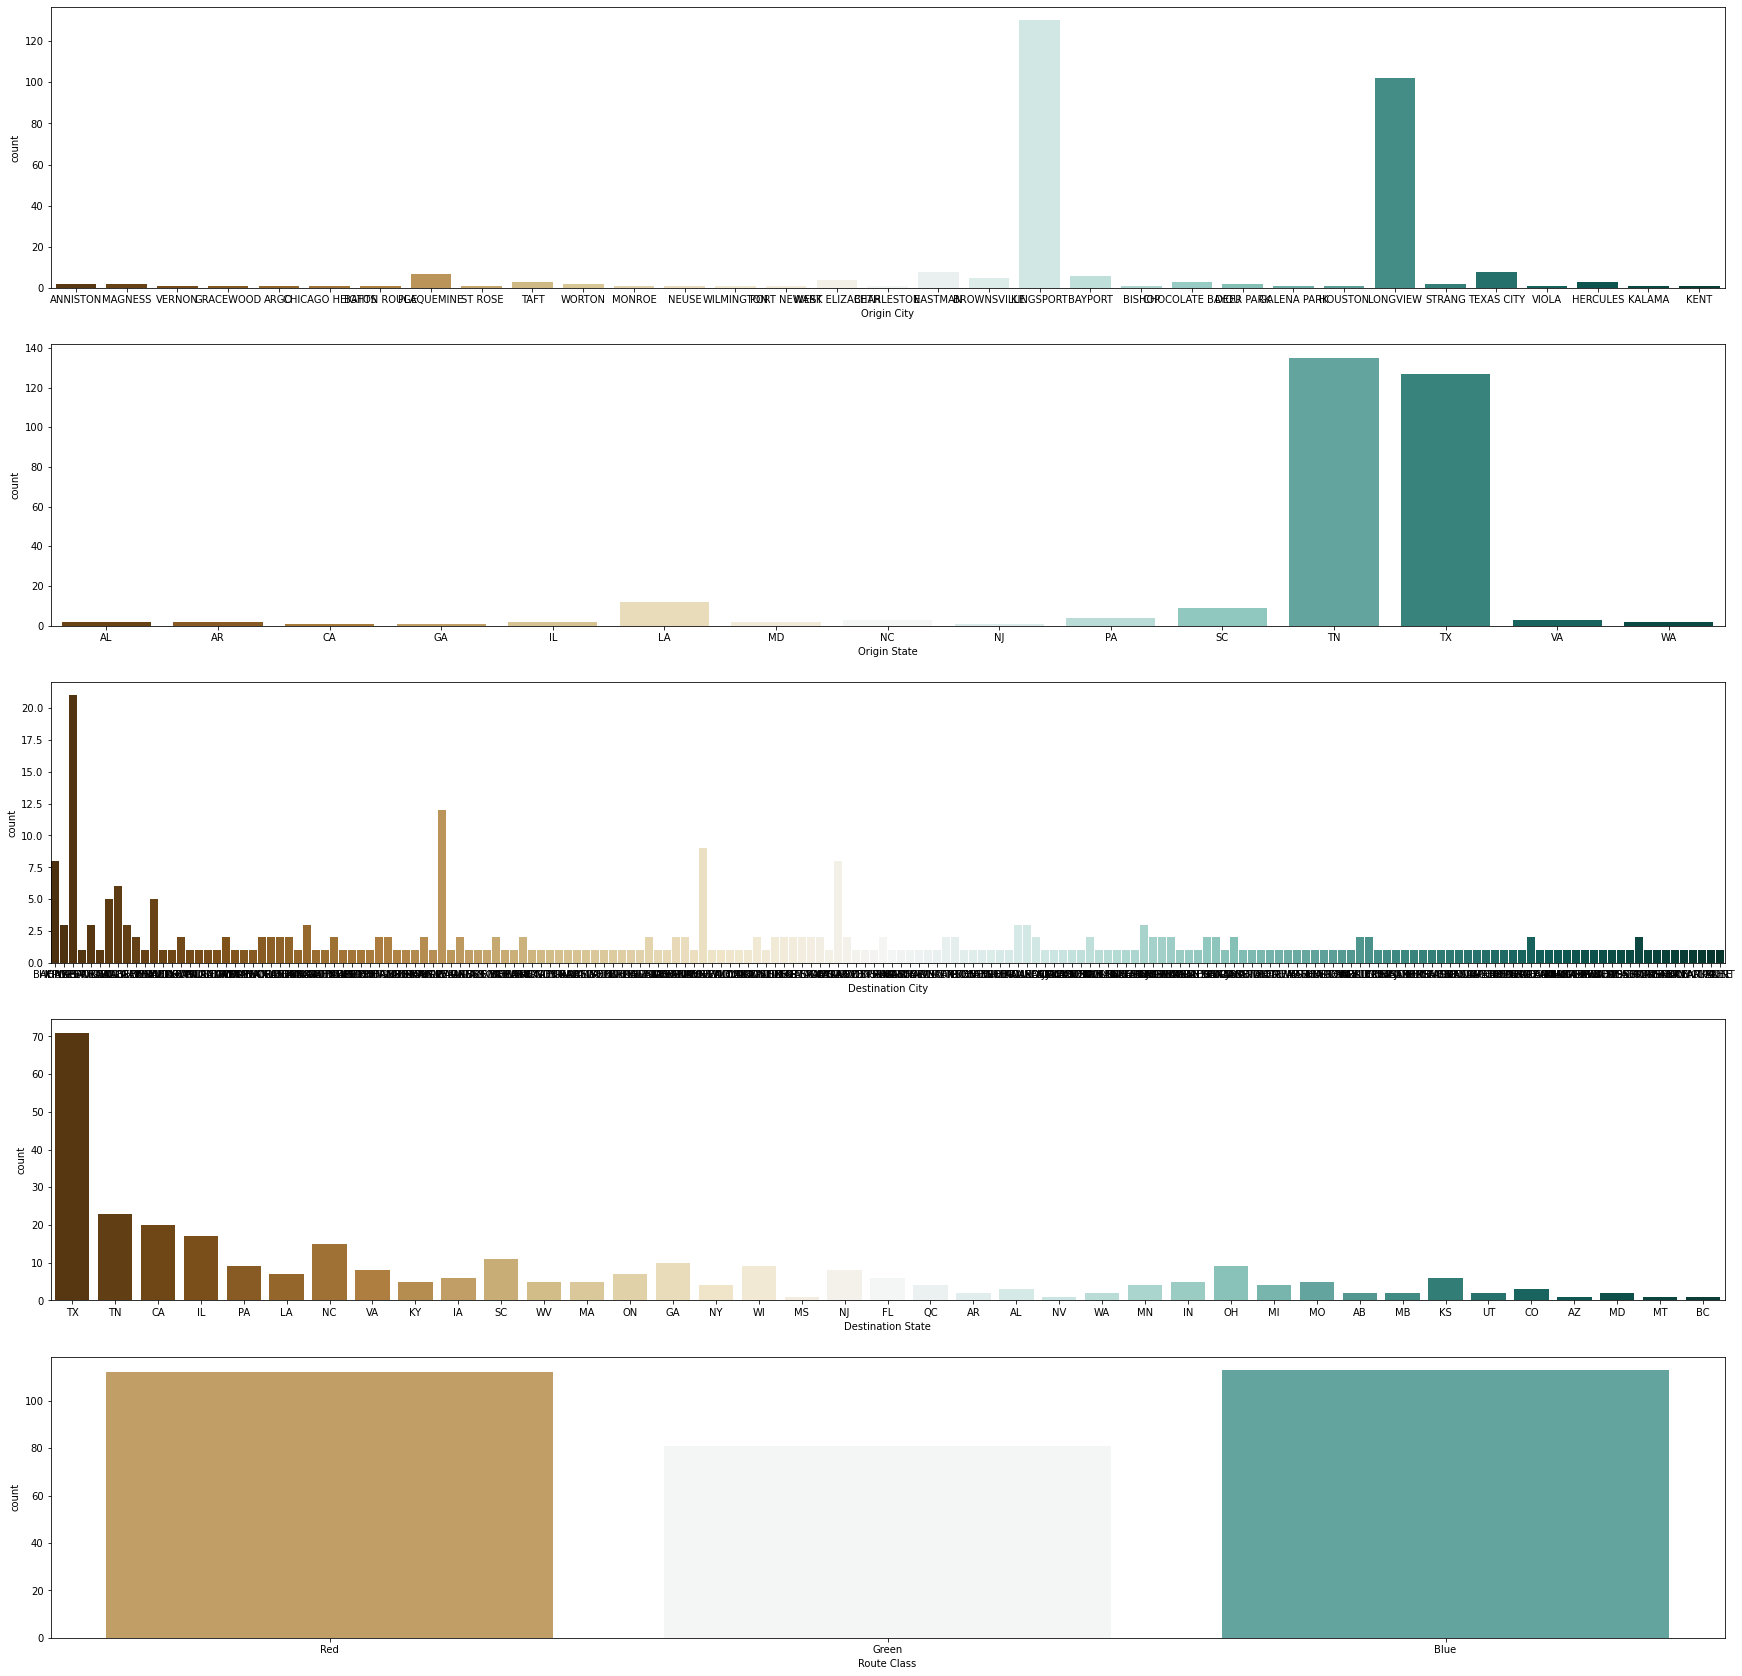

In [797]:
#Exploring ditribution of  categorical variables in the datset

fig, ax = plt.subplots(figsize=(30,30), ncols=1, nrows=5)
sns.countplot(x="Origin City", data=df, ax=ax[0],palette="BrBG")
sns.countplot(x="Origin State", data=df, ax=ax[1],palette="BrBG")
sns.countplot(x="Destination City", data=df, ax=ax[2],palette="BrBG")
sns.countplot(x="Destination State", data=df, ax=ax[3],palette="BrBG")
sns.countplot(x="Route Class", data=df, ax=ax[4],palette="BrBG")

plt.show()

In [798]:
for feature in df.columns[:]:
    if df[feature].dtype=='object':
        print(feature,":",len(df[feature].unique()),'labels')
        #

Origin City : 33 labels
Origin State : 15 labels
Destination City : 186 labels
Destination State : 39 labels
Route Class : 3 labels
Priority : 6 labels


## Destination City labels are so many compared to other levels of categorical variables

In [799]:
#Checking for number of unique values in categorical columns 
for i in df.columns:
    if df[i].dtype =='object':
        print(f"{i}: column has {len(df[i].unique())} unique values with {df[i].unique()} \n")

Origin City: column has 33 unique values with ['ANNISTON' 'MAGNESS' 'VERNON' 'GRACEWOOD' 'ARGO' 'CHICAGO HEIGHTS'
 'BATON ROUGE' 'PLAQUEMINE' 'ST ROSE' 'TAFT' 'WORTON' 'MONROE' 'NEUSE'
 'WILMINGTON' 'PORT NEWARK' 'WEST ELIZABETH' 'CHARLESTON' 'EASTMAN'
 'BROWNSVILLE' 'KINGSPORT' 'BAYPORT' 'BISHOP' 'CHOCOLATE BAYOU'
 'DEER PARK' 'GALENA PARK' 'HOUSTON' 'LONGVIEW' 'STRANG' 'TEXAS CITY'
 'VIOLA' 'HERCULES' 'KALAMA' 'KENT'] 

Origin State: column has 15 unique values with ['AL' 'AR' 'CA' 'GA' 'IL' 'LA' 'MD' 'NC' 'NJ' 'PA' 'SC' 'TN' 'TX' 'VA'
 'WA'] 

Destination City: column has 186 unique values with ['BAYPORT' 'HOUSTON' 'KINGSPORT' 'HARPERTOWN' 'SAUGET' 'WEST ELIZABETH'
 'ARGO' 'LONGVIEW' 'TALLA BENA' 'CROSBY' 'GARLAND' 'VERNON' 'HICKORY'
 'HUDSON' 'NEVILLE ISLAND' 'DANVILLE' 'BROWN SUMMIT' 'BARDSTOWN'
 'SIOUX CITY' 'RURAL RETREAT' 'GASTON' 'FLORENCE' 'MILLWOOD'
 'INDIAN ORCHARD' 'HAMILTON' 'CALHOUN' 'EASTMAN' 'ASHEBORO' 'TEXAS CITY'
 'NIAGARA FALLS' 'NEUSE' 'CHARITY CHURCH' 'MIDDLETON' 

In [800]:
#Checking for number of unique value counts in categorical columns 
for i in df.columns:
    if df[i].dtype =='object':
        print(f"{i}: column has {len(df[i].unique())} unique values, Below are top 5 value counts : \n {pd.DataFrame(df[i].value_counts().nlargest(n=5))} \n")

Origin City: column has 33 unique values, Below are top 5 value counts : 
             Origin City
KINGSPORT           130
LONGVIEW            102
TEXAS CITY            8
EASTMAN               8
PLAQUEMINE            7 

Origin State: column has 15 unique values, Below are top 5 value counts : 
     Origin State
TN           135
TX           127
LA            12
SC             9
PA             4 

Destination City: column has 186 unique values, Below are top 5 value counts : 
              Destination City
KINGSPORT                  21
EAGLE PASS                 12
BROWNSVILLE                 9
BAYPORT                     8
LAREDO                      8 

Destination State: column has 39 unique values, Below are top 5 value counts : 
     Destination State
TX                 71
TN                 23
CA                 20
IL                 17
NC                 15 

Route Class: column has 3 unique values, Below are top 5 value counts : 
        Route Class
Blue           113
Red      

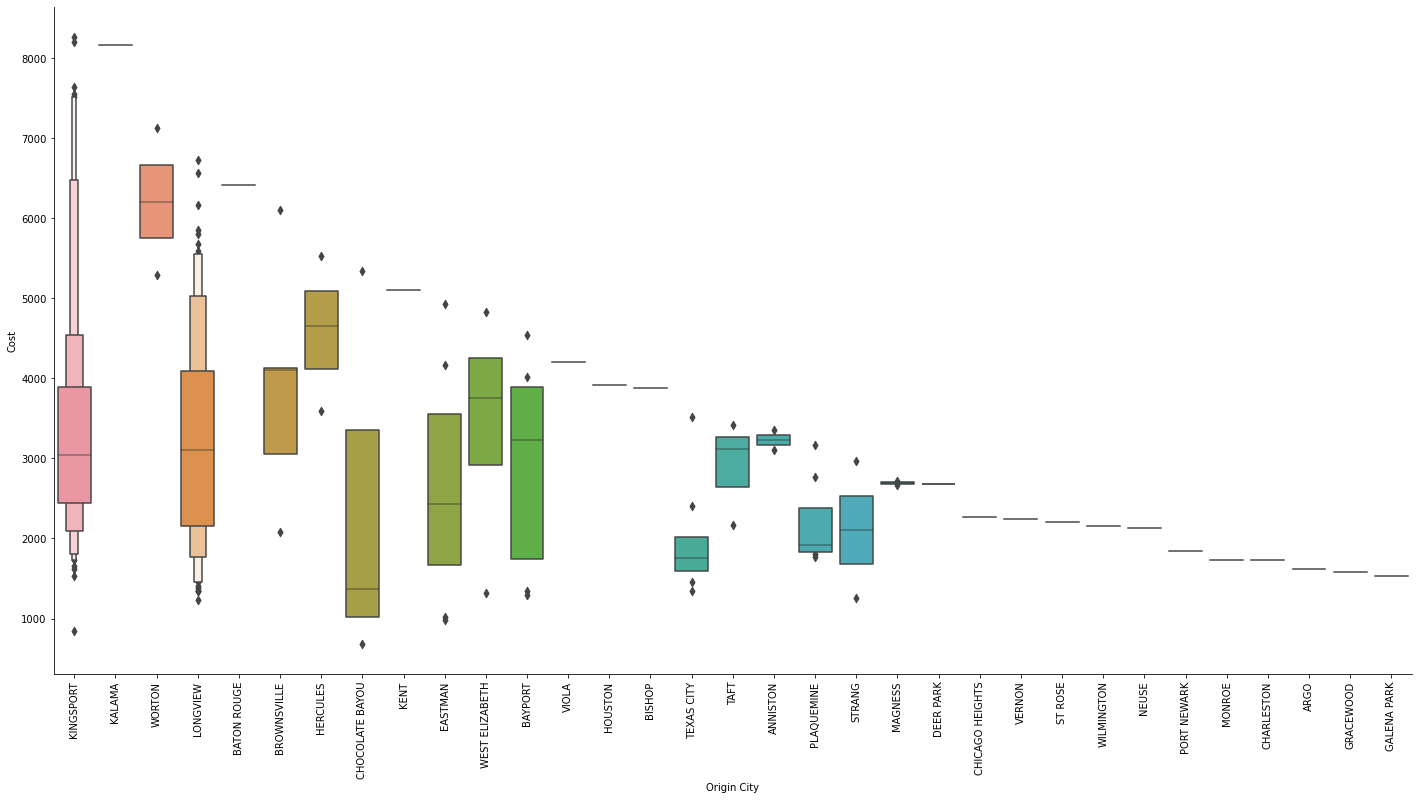

In [801]:
# Origin City vs Cost
sns.catplot(y = "Cost", x = "Origin City", data = df.sort_values("Cost", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.xticks(rotation = 90)
# saving the figure.
# plt.savefig("squares1.png",
#             bbox_inches ="tight",
#             pad_inches = 1,
#             transparent = True,
#             facecolor ="y",
#             edgecolor ='w',
#             orientation ='landscape')
plt.show()

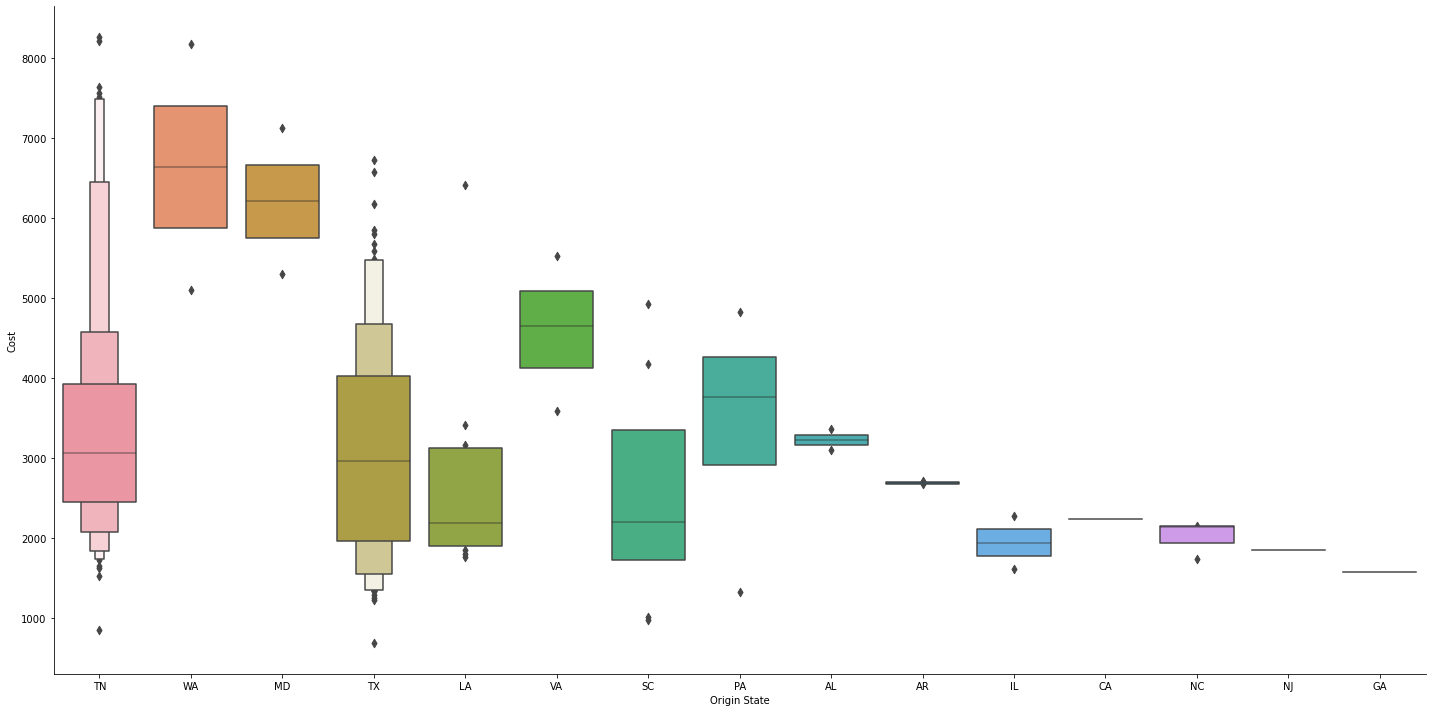

In [802]:
# Origin State vs Cost
sns.catplot(y = "Cost", x = "Origin State", data = df.sort_values("Cost", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.show()

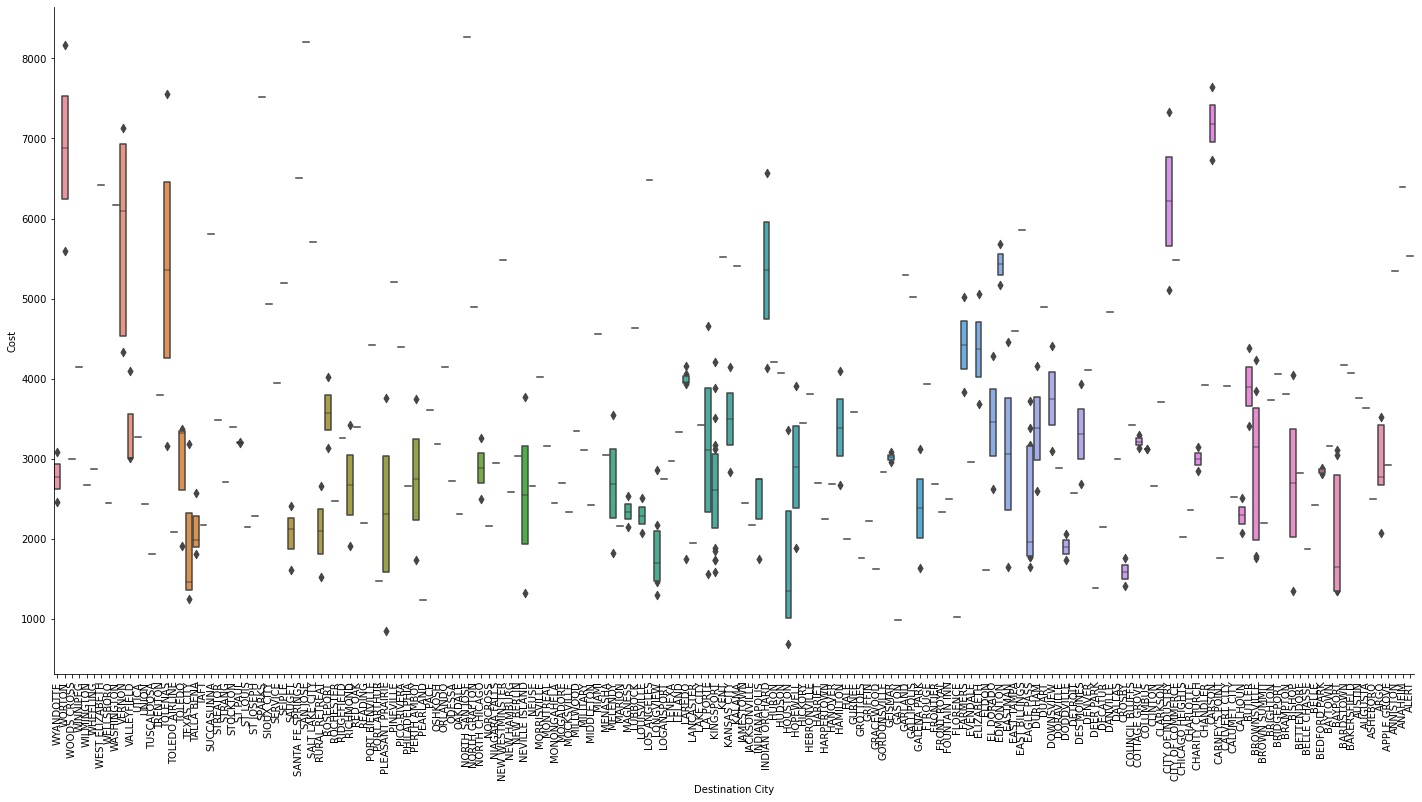

In [803]:
# Destination City vs Cost
sns.catplot(y = "Cost", x = "Destination City", data = df.sort_values("Destination City", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.xticks(rotation = 90)
plt.show()

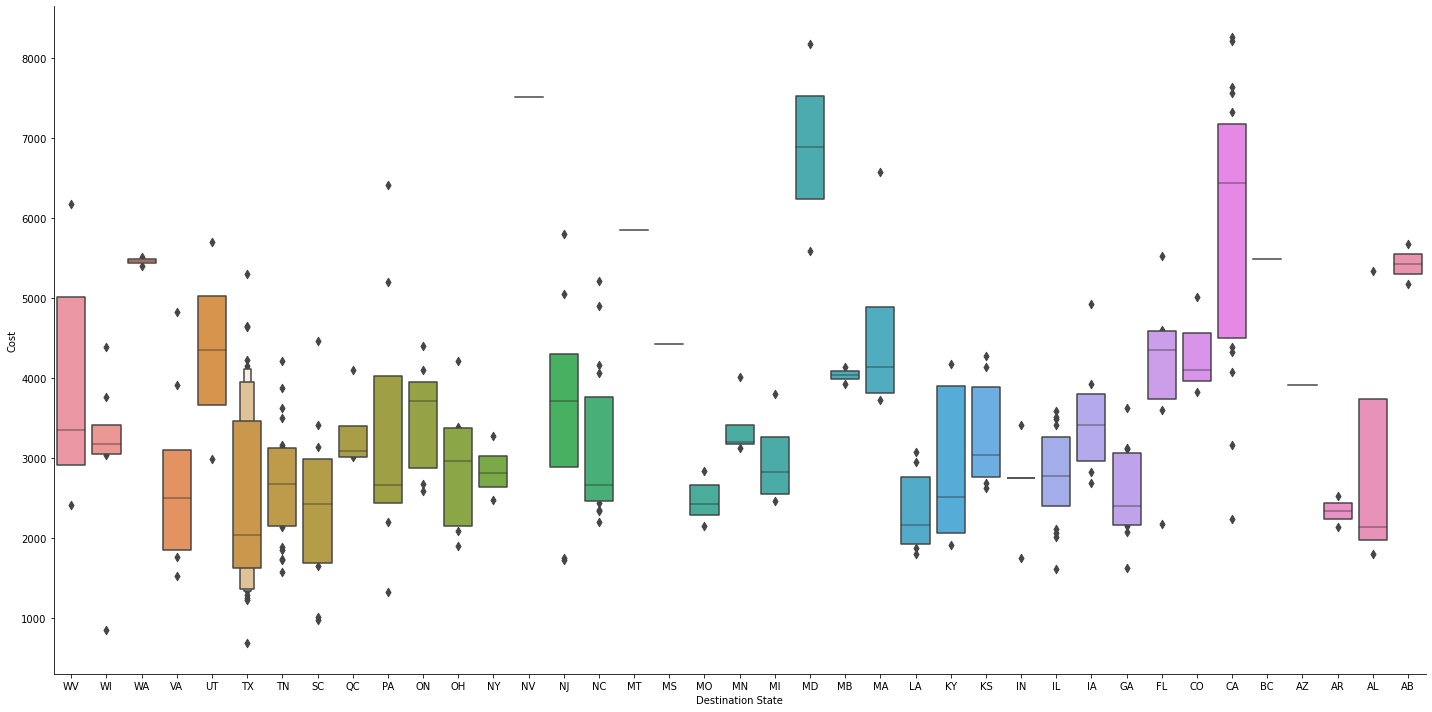

In [804]:
# Destination State vs Cost
sns.catplot(y = "Cost", x = "Destination State", data = df.sort_values("Destination State", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.show()

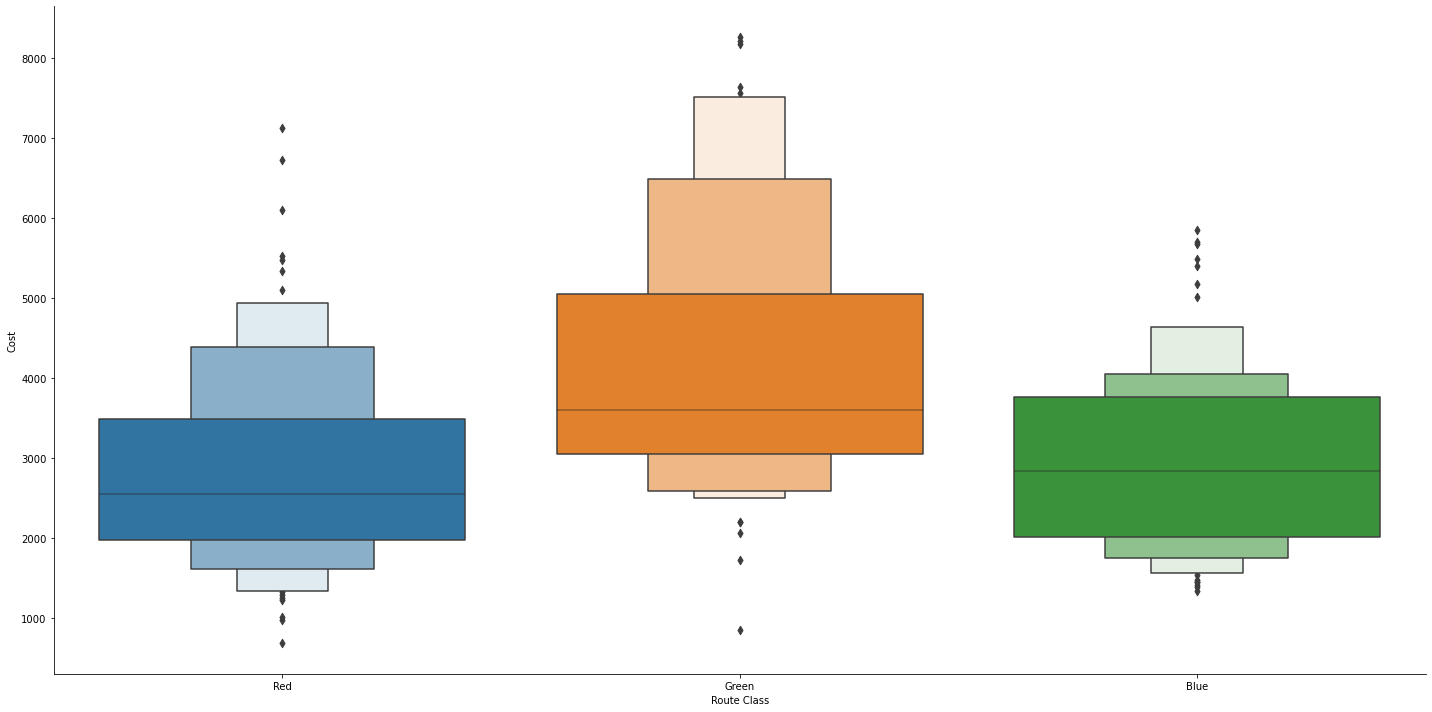

In [805]:
# Route Class vs Cost
sns.catplot(y = "Cost", x = "Route Class", data = df.sort_values("Route Class", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.show()

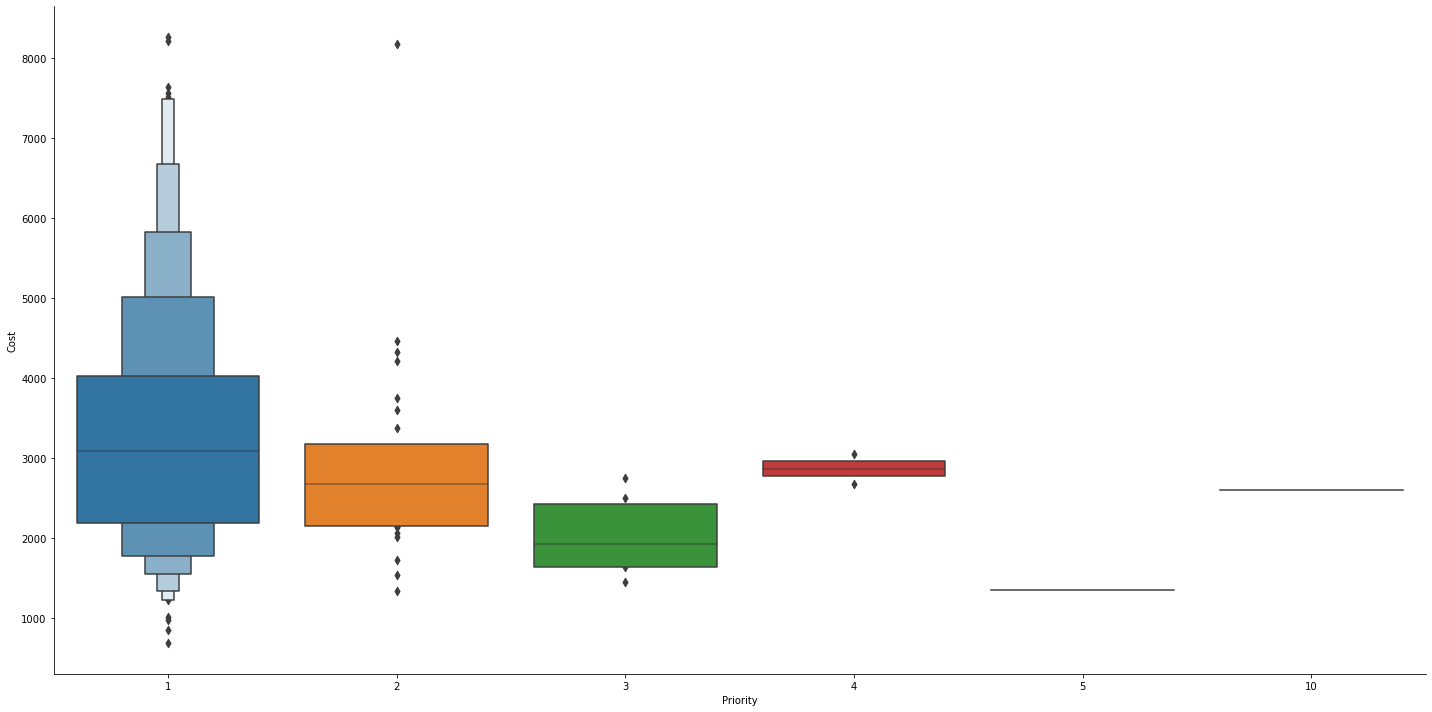

In [806]:
# Priority vs Cost
sns.catplot(y = "Cost", x = "Priority", data = df.sort_values("Priority", ascending = False), kind="boxen", height = 10, aspect = 2)
plt.show()

## Aggregations

In [807]:
Priority_origin=df.groupby(['Origin State','Origin City','Priority']).size().reset_index().rename(columns={0:'Priority Count'})
Priority_origin

,Origin State,Origin City,Priority,Priority Count
0,AL,ANNISTON,1,2
1,AR,MAGNESS,1,1
2,AR,MAGNESS,2,1
3,CA,VERNON,1,1
4,GA,GRACEWOOD,1,1
5,IL,ARGO,1,1
6,IL,CHICAGO HEIGHTS,1,1
7,LA,BATON ROUGE,1,1
8,LA,PLAQUEMINE,1,6
9,LA,PLAQUEMINE,2,1


In [808]:
#df.sort_values("Route Class", ascending = False)
df["Route Class"].value_counts()

Blue     113
Red      112
Green     81
Name: Route Class, dtype: int64

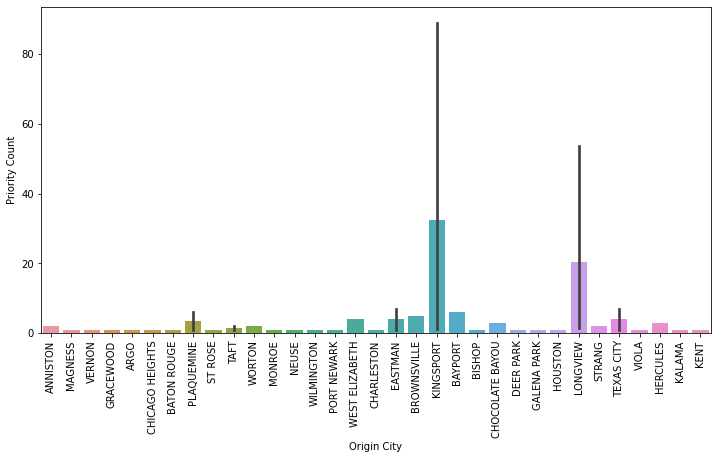

In [809]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Origin City',y='Priority Count',data=Priority_origin)
plt.xticks(rotation = 90)
plt.show()

## Observations on Origin vs Priority
-Ships originating from Kingsport and Longview has the highest priority

In [810]:
Priority_destination=df.groupby(['Destination State','Destination City','Priority']).size().reset_index().rename(columns={0:'Priority Count'})
Priority_destination

,Destination State,Destination City,Priority,Priority Count
0,AB,EDMONTON,1,2
1,AL,ANNISTON,1,1
2,AL,DECATUR,1,1
3,AL,TUSCALOOSA,1,1
4,AR,MAGNESS,1,1
...,...,...,...,...
204,WV,APPLE GROVE,1,1
205,WV,BELLE,1,1
206,WV,GALLIPOLIS,1,1
207,WV,MILLWOOD,1,1


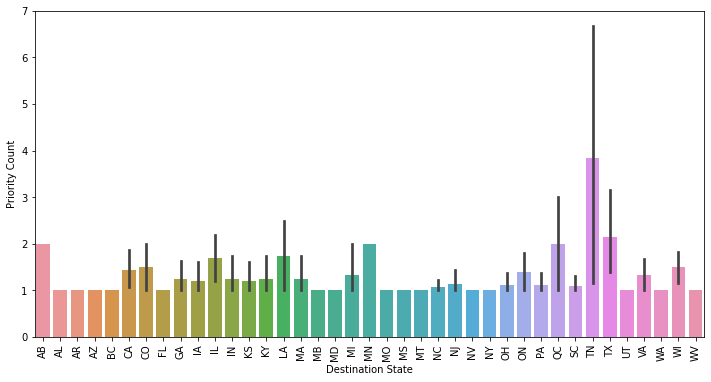

In [811]:

import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Destination State',y='Priority Count',data=Priority_destination)
plt.xticks(rotation = 90)
plt.show()

## Observations on Destination vs Priority
-Not much observations

## RouteClass vs origin

In [812]:
RouteClass_origin=df.groupby(['Origin State','Origin City','Route Class']).size().reset_index().rename(columns={0:'RouteClassCount'})
RouteClass_origin

,Origin State,Origin City,Route Class,RouteClassCount
0,AL,ANNISTON,Green,1
1,AL,ANNISTON,Red,1
2,AR,MAGNESS,Green,1
3,AR,MAGNESS,Red,1
4,CA,VERNON,Red,1
5,GA,GRACEWOOD,Red,1
6,IL,ARGO,Red,1
7,IL,CHICAGO HEIGHTS,Blue,1
8,LA,BATON ROUGE,Green,1
9,LA,PLAQUEMINE,Green,1


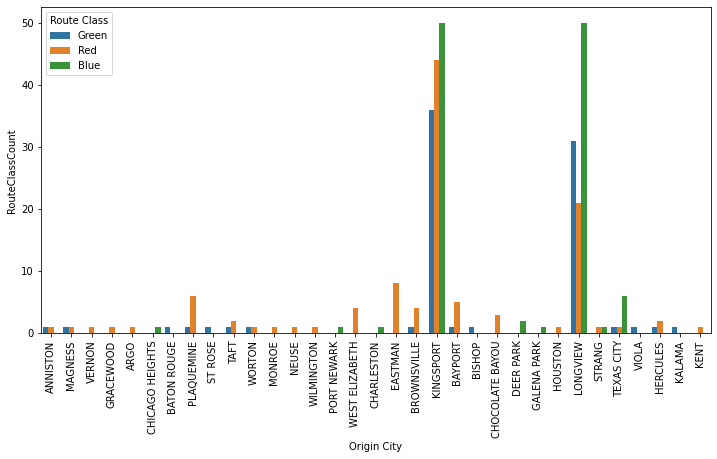

In [813]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Origin City',y='RouteClassCount',hue='Route Class',data=RouteClass_origin)
plt.xticks(rotation = 90)
plt.show()

## RouteClass vs origin

In [814]:
RouteClass_Destination=df.groupby(['Destination State','Destination City','Route Class']).size().reset_index().rename(columns={0:'RouteClassCount'})
RouteClass_Destination

,Destination State,Destination City,Route Class,RouteClassCount
0,AB,EDMONTON,Blue,2
1,AL,ANNISTON,Red,1
2,AL,DECATUR,Red,1
3,AL,TUSCALOOSA,Blue,1
4,AR,MAGNESS,Green,1
...,...,...,...,...
217,WV,APPLE GROVE,Red,1
218,WV,BELLE,Red,1
219,WV,GALLIPOLIS,Green,1
220,WV,MILLWOOD,Red,1


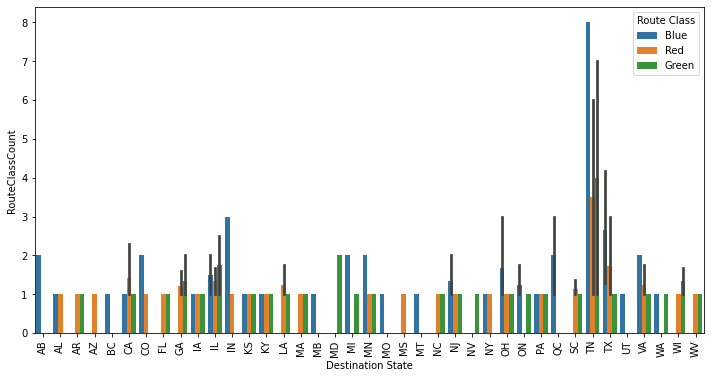

In [815]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 6)
sns.barplot(x='Destination State',y='RouteClassCount',hue='Route Class',data=RouteClass_Destination)
plt.xticks(rotation = 90)
plt.show()

## Priority vs Cost

In [816]:
df['Priority'].value_counts()

1     267
2      29
3       6
4       2
10      1
5       1
Name: Priority, dtype: int64

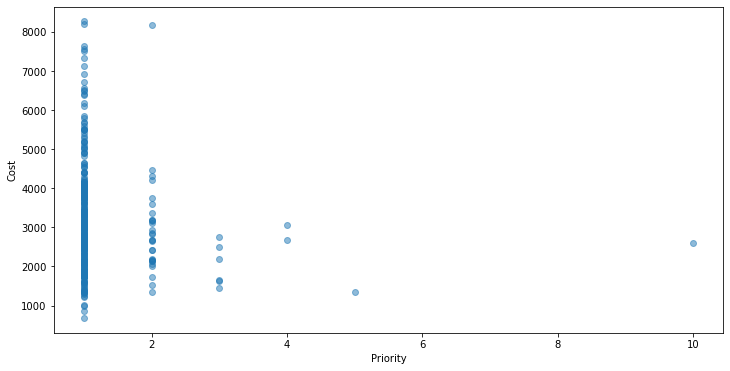

In [817]:
plt.scatter(df['Priority'],df['Cost'], alpha = 0.5)
plt.xlabel("Priority")
plt.ylabel("Cost")
plt.show()

## Observations on Priority vs Cost
-Most of the ships (267/306=87%) have highest priority 1

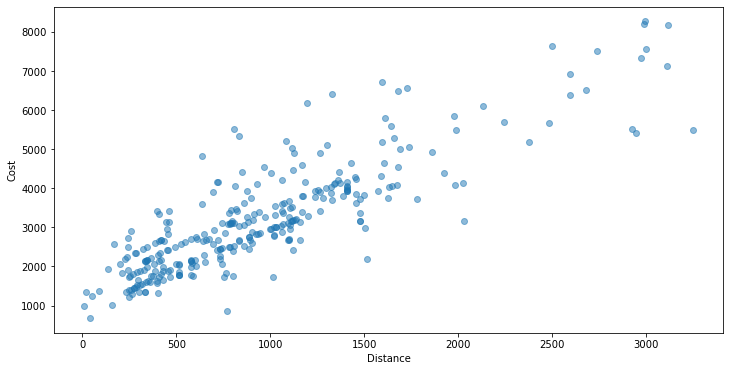

In [818]:
plt.scatter(df['Distance'],df['Cost'], alpha = 0.5)
plt.xlabel("Distance")
plt.ylabel("Cost")
plt.show()

## Observations on Distance vs Cost
#-There is a good linear relationship (Corr:0.86)-  As Distance increases,Shipping cost increases

# will do transormations on data

## Outliers

##### Which Machine LEarning Models Are Sensitive To Outliers?
1. Naivye Bayes Classifier--- Not Sensitive To Outliers
2. SVM--------                Not Sensitive To Outliers          
3. Linear Regression----------  Sensitive To Outliers
4. Logistic Regression-------   Sensitive To Outliers
5. Decision Tree Regressor or Classifier---- Not Sensitive
6. Ensemble(RF,XGboost,GB)------- Not Sensitive
7. KNN--------------------------- Not Sensitive 
8. Kmeans------------------------ Sensitive
9. Hierarichal------------------- Sensitive 
10. PCA-------------------------- Sensitive 
11. Neural Networks-------------- Sensitive

### What are the criteria to identify an outlier?

1. Data point that falls outside of 1.5 times of an interquartile range above the 3rd quartile and below the 1st quartile
2. Data point that falls outside of 3 standard deviations. we can use a z score and if the z score falls outside of 2 standard deviation

### What is the reason for an outlier to exists in a dataset?

1. Variability in the data
2. An experimental measurement error

### What are the impacts of having outliers in a dataset?

1. It causes various problems during our statistical analysis
2. It may cause a significant impact on the mean and the standard deviation

### Various ways of finding the outlier.
1. Using scatter plots
2. Box plot
3. using z score
4. using the IQR interquantile range



## InterQuantile Range

75%- 25% values in a dataset

### Steps
#### 1. Arrange the data in increasing order
#### 2. Calculate first(q1) and third quartile(q3)
#### 3. Find interquartile range (q3-q1)
#### 4.Find lower bound q1*1.5
#### 5.Find upper bound q3*1.5

Anything that lies outside of lower and upper bound is an outlier

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Distance', ylabel='Density'>

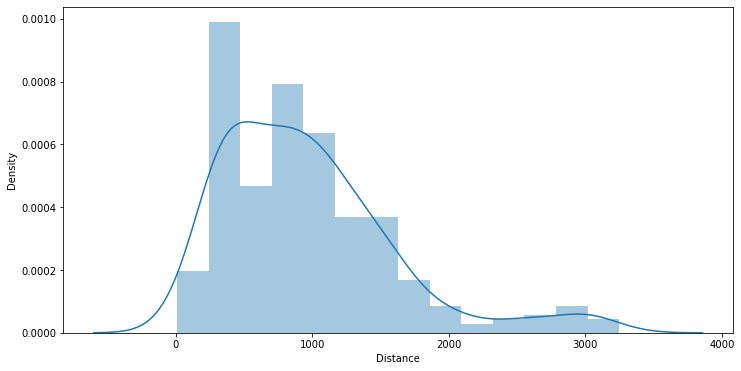

In [819]:
sns.distplot(df['Distance'])

#### Gaussian Distributed

Text(0, 0.5, 'No of Ships')

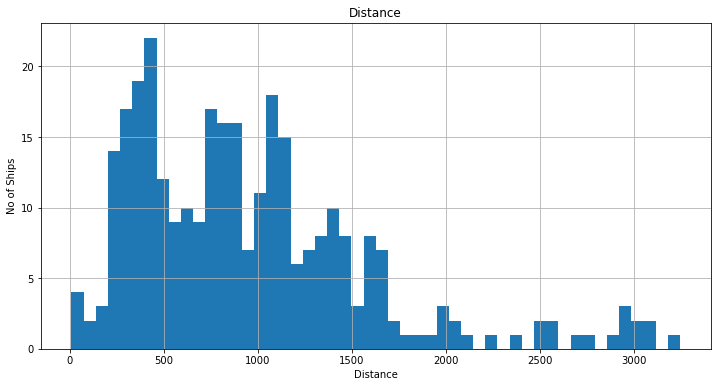

In [820]:
figure=df.Distance.hist(bins=50)
figure.set_title('Distance')
figure.set_xlabel('Distance')
figure.set_ylabel('No of Ships')

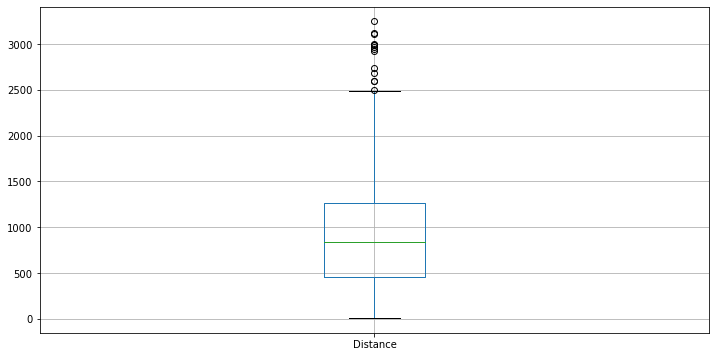

In [821]:
figure=df.boxplot(column="Distance")

In [822]:
df['Distance'].describe()

count     306.000000
mean      960.526144
std       639.685113
min         9.000000
25%       452.250000
50%       835.000000
75%      1264.750000
max      3247.000000
Name: Distance, dtype: float64

In [823]:
##### Assuming Age follows A Gaussian Distribution we will calculate the boundaries which differentiates the outliers

uppper_boundary=df['Distance'].mean() + 3* df['Distance'].std()
lower_boundary=df['Distance'].mean() - 3* df['Distance'].std()
print(lower_boundary), print(uppper_boundary),print(df['Distance'].mean())

-958.5291946996803
2879.5814822813795
960.5261437908497


(None, None, None)

In [824]:
#### Lets compute the Interquantile range to calculate the boundaries
IQR=df.Distance.quantile(0.75)-df.Distance.quantile(0.25)
lower_bridge=df['Distance'].quantile(0.25)-(IQR*1.5)
upper_bridge=df['Distance'].quantile(0.75)+(IQR*1.5)
print(lower_bridge), print(upper_bridge)

-766.5
2483.5


(None, None)

In [825]:
outlierremoved_data=df.copy()

In [826]:
outlierremoved_data.loc[outlierremoved_data['Distance']>2879]

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
21,WORTON,MD,VERNON,CA,Red,1,3112,7126.23
58,KINGSPORT,TN,CITY OF INDUSTRY,CA,Green,1,2973,7330.43
86,KINGSPORT,TN,KENT,WA,Green,1,2922,5518.36
108,KINGSPORT,TN,TOLENAS,CA,Green,1,2997,7557.31
155,KINGSPORT,TN,NORTH SAN JOSE,CA,Green,1,2990,8265.17
172,KINGSPORT,TN,SAN JOSE,CA,Green,1,2986,8207.39
243,LONGVIEW,TX,KALAMA,WA,Blue,1,2942,5404.06
275,LONGVIEW,TX,NEW WESTMINSTER,BC,Blue,1,3247,5481.73
304,KALAMA,WA,WORTON,MD,Green,2,3117,8172.43


In [827]:
outlierremoved_data.drop(outlierremoved_data.loc[outlierremoved_data['Distance']>2879].index, inplace=True)

In [828]:
outlierremoved_data=outlierremoved_data.reset_index(drop=True)

In [829]:
outlierremoved_data

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49
...,...,...,...,...,...,...,...,...
292,VIOLA,TX,KINGSPORT,TN,Green,2,1361,4209.23
293,HERCULES,VA,GURNEE,IL,Red,1,1060,3587.94
294,HERCULES,VA,ALERT,FL,Red,1,806,5525.39
295,HERCULES,VA,LA PORTE,TX,Green,1,1431,4653.60


## Handling Categorical Data
### One can find many ways to handle categorical data. Some of them categorical data are,

### **Nominal data** --> data are not in any order --> **OneHotEncoder** is used in this case
### **Ordinal data** --> data are in order --> **LabelEncoder** is used in this case

In [830]:
final_dataset=pd.get_dummies(df)
# final_dataset=pd.get_dummies(df,drop_first=False) 

In [831]:
final_dataset.columns

Index(['Distance', 'Cost', 'Origin City_ANNISTON', 'Origin City_ARGO',
       'Origin City_BATON ROUGE', 'Origin City_BAYPORT', 'Origin City_BISHOP',
       'Origin City_BROWNSVILLE', 'Origin City_CHARLESTON',
       'Origin City_CHICAGO HEIGHTS',
       ...
       'Destination State_WV', 'Route Class_Blue', 'Route Class_Green',
       'Route Class_Red', 'Priority_1', 'Priority_2', 'Priority_3',
       'Priority_4', 'Priority_5', 'Priority_10'],
      dtype='object', length=284)

In [832]:
final_dataset.shape

(306, 284)

In [833]:
outlierremoved_data.head()

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49


In [834]:
outlierremoved_data.dtypes

Origin City           object
Origin State          object
Destination City      object
Destination State     object
Route Class           object
Priority              object
Distance               int64
Cost                 float64
dtype: object

In [835]:
outlierremoved_data['Priority']=outlierremoved_data['Priority'].astype(int)

In [836]:
outlierremoved_data

,Origin City,Origin State,Destination City,Destination State,Route Class,Priority,Distance,Cost
0,ANNISTON,AL,BAYPORT,TX,Red,1,808,3105.12
1,ANNISTON,AL,HOUSTON,TX,Green,1,779,3357.28
2,MAGNESS,AR,KINGSPORT,TN,Green,2,657,2670.23
3,MAGNESS,AR,BAYPORT,TX,Red,1,610,2715.14
4,VERNON,CA,HARPERTOWN,CA,Red,1,235,2241.49
...,...,...,...,...,...,...,...,...
292,VIOLA,TX,KINGSPORT,TN,Green,2,1361,4209.23
293,HERCULES,VA,GURNEE,IL,Red,1,1060,3587.94
294,HERCULES,VA,ALERT,FL,Red,1,806,5525.39
295,HERCULES,VA,LA PORTE,TX,Green,1,1431,4653.60


In [837]:
outlierremoved_catdummies_data=pd.get_dummies(outlierremoved_data)

In [838]:
outlierremoved_catdummies_data

,Priority,Distance,Cost,Origin City_ANNISTON,Origin City_ARGO,Origin City_BATON ROUGE,Origin City_BAYPORT,Origin City_BISHOP,Origin City_BROWNSVILLE,Origin City_CHARLESTON,...,Destination State_SC,Destination State_TN,Destination State_TX,Destination State_UT,Destination State_VA,Destination State_WI,Destination State_WV,Route Class_Blue,Route Class_Green,Route Class_Red
0,1,808,3105.12,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,779,3357.28,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2,657,2670.23,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,610,2715.14,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,235,2241.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,2,1361,4209.23,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
293,1,1060,3587.94,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
294,1,806,5525.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
295,1,1431,4653.60,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [839]:
outlierremoved_catdummies_data.shape

(297, 271)

  Outlierremoved_catdummies_data['Priority']=outlierremoved_catdummies_data['Priority'].astype('object')

In [840]:
outlierremoved_catdummies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Columns: 271 entries, Priority to Route Class_Red
dtypes: float64(1), int32(1), int64(1), uint8(268)
memory usage: 83.7 KB


## 1.Algo-1=Applying Linear Regression

## Applying standard scalar to distance variable
### Standarisation: We use the Standardscaler from sklearn library
## Scaling the 'Distance' feature

In [943]:
#Standardizing the numerical data as we used the log transforamtion
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [944]:
outlierremoved_catdummies_data['Distance'] = standardize(outlierremoved_catdummies_data['Distance'])

In [945]:
X=outlierremoved_catdummies_data.drop('Cost',axis=1)
X= sm.add_constant(X)
y=outlierremoved_catdummies_data['Cost']

In [946]:
X.head()

,const,Priority,Distance,Origin City_ANNISTON,Origin City_ARGO,Origin City_BATON ROUGE,Origin City_BAYPORT,Origin City_BISHOP,Origin City_BROWNSVILLE,Origin City_CHARLESTON,...,Destination State_SC,Destination State_TN,Destination State_TX,Destination State_UT,Destination State_VA,Destination State_WI,Destination State_WV,Route Class_Blue,Route Class_Green,Route Class_Red
0,1.0,1,-0.167850,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1.0,1,-0.222079,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1.0,2,-0.450214,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1.0,1,-0.538102,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1.0,1,-1.239339,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [947]:
#Feature Importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# scaler=StandardScaler()
# ### fit vs fit_transform
# X_train_scaled=scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [948]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
#fit OLS model

lm_sm=sm.OLS(y_train,X_train).fit()
#making predictions
y_pred_train=lm_sm.predict(X_train)
y_pred_test=lm_sm.predict(X_test)

#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-sqaure-------------------------------------------
R-sq for test data is 0.4010533163386507
R-sq for train data is 0.9716997829557256
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 830.7256884445679
RMSE for train data is 214.4132118360611
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     9.944
Date:                Sat, 18 Jun 2022   Prob (F-statistic):           1.04e-16
Time:                        17:55:49   Log-Likelihood:                -1608.5
No. Observations:                 237   AIC:                             3585.
Df Residuals:                      53   BIC:                             4223.
Df Model:                         183        

## Obervations of linear regresion- not good at all to fit 280 columns

## 2.Applying Linear Regression #Applying for 10 columns 

In [957]:
cols=['Distance','Destination State_CA','Route Class_Green','Route Class_Blue','Destination State_TX','Origin State_TN','Destination City_CARSON','Destination City_READING','Destination State_WV','Route Class_Red']

In [958]:
X=outlierremoved_catdummies_data[cols]
X= sm.add_constant(X)
y=outlierremoved_catdummies_data['Cost']

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [959]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [960]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
#fit OLS model
lm_sm=sm.OLS(y_train,X_train).fit()
#making predictions
y_pred_train=lm_sm.predict(X_train)
y_pred_test=lm_sm.predict(X_test)

#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-sqaure-------------------------------------------
R-sq for test data is 0.5191329546373067
R-sq for train data is 0.8006980491693404
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 661.9344781772894
RMSE for train data is 569.0002198154563
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sat, 18 Jun 2022   Prob (F-statistic):           2.07e-74
Time:                        18:00:35   Log-Likelihood:                -1839.8
No. Observations:                 237   AIC:                             3700.
Df Residuals:                     227   BIC:                             3734.
Df Model:                           9        

## Observations of X having 10 imp variables

## 3.Applying Linear Regression #Applying for 7-8 columns 

In [961]:
cols2=['Distance','Destination State_CA','Route Class_Green','Route Class_Blue','Destination City_CARSON','Destination City_READING','Destination State_WV','Route Class_Red']

In [962]:
X=outlierremoved_catdummies_data[cols2]
X= sm.add_constant(X)
y=outlierremoved_catdummies_data['Cost']

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [963]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [964]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
#fit OLS model
lm_sm=sm.OLS(y_train,X_train).fit()
#making predictions
y_pred_train=lm_sm.predict(X_train)
y_pred_test=lm_sm.predict(X_test)

#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-sqaure-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-sqaure-------------------------------------------
R-sq for test data is 0.5158201856747378
R-sq for train data is 0.7998599684341968
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 663.9016719211593
RMSE for train data is 570.1953106176494
                            OLS Regression Results                            
Dep. Variable:                   Cost   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     130.7
Date:                Sat, 18 Jun 2022   Prob (F-statistic):           2.54e-76
Time:                        18:01:41   Log-Likelihood:                -1840.3
No. Observations:                 237   AIC:                             3697.
Df Residuals:                     229   BIC:                             3724.
Df Model:                           7        

### Testing Multi collinearity

In [966]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = outlierremoved_catdummies_data[cols2]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                    feature       VIF
0                  Distance  1.624677
1      Destination State_CA  1.527747
2         Route Class_Green  1.092098
3          Route Class_Blue  1.017076
4   Destination City_CARSON  1.147817
5  Destination City_READING  1.014433
6      Destination State_WV  1.012773
7           Route Class_Red  1.352413


## Observations on Multi collinearity== As VIF is <2..So no Multi collinearity in X

## Below graph is for  LR training data Actuals VS Predictions

Text(0, 0.5, 'Ship Cost')

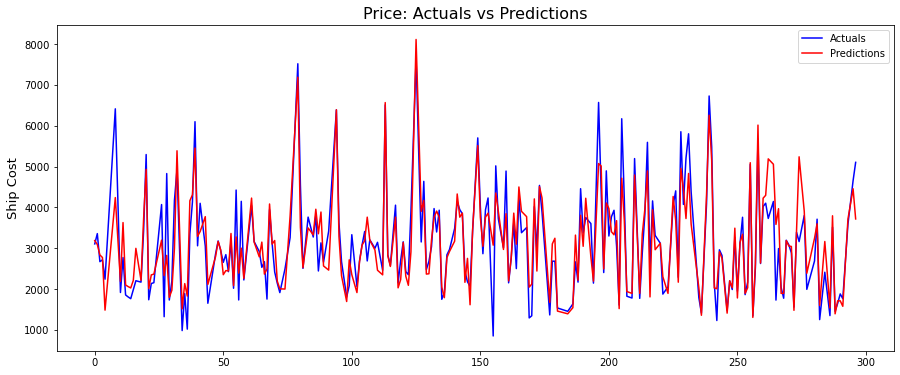

In [967]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_train.index,y=y_train,label='Actuals',color='blue',ax=ax)
sns.lineplot(x=y_train.index,y=y_pred_train,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions', fontsize=16)
ax.set_ylabel('Ship Cost',fontsize=13)

## Below graph is for  LR training data Actuals VS Predictions

Text(0, 0.5, 'Ship Cost')

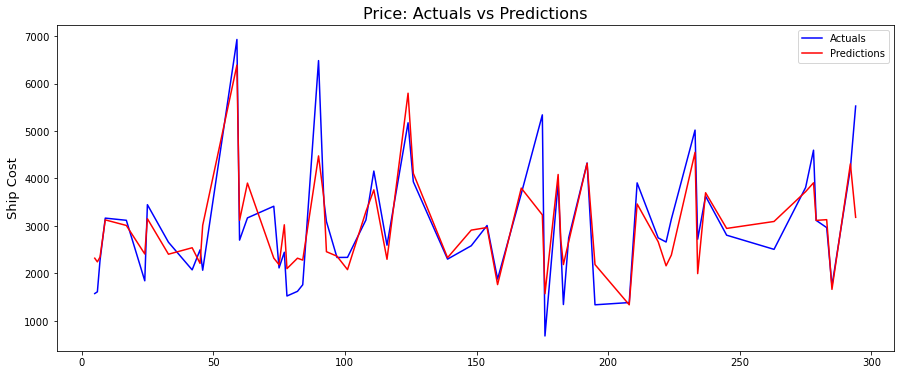

In [968]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_test.index,y=y_test,label='Actuals',color='blue',ax=ax)
sns.lineplot(x=y_test.index,y=y_pred_test,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions', fontsize=16)
ax.set_ylabel('Ship Cost',fontsize=13)

### <b> Above Graph shows predictions miss the actual values at some places but given that we want to avoid overfitting and want our model to generalize well and perform well on unseen test data we will have to compromise a bit (bias-variance tradeoff)

#  Linear Regression Assumptions Validation

## Checking Assumptions for Linear Regression model

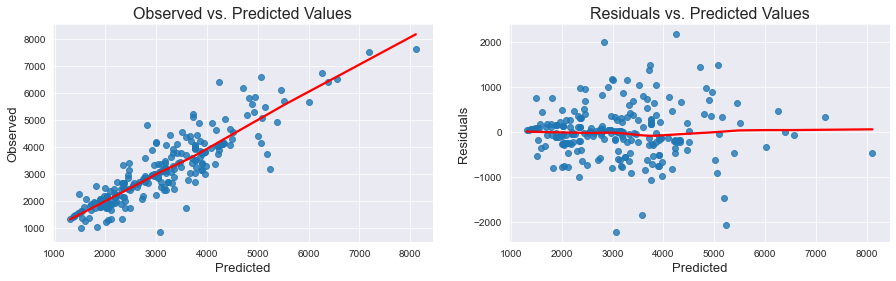

In [972]:
#To detect linearity lets inspect plots of observed vs. predicted values or residuals vs. predicted values. 
#The desired outcome is that points are symmetrically distributed around a diagonal line in the former plot & 
#around horizontal line in the latter one

def linearity_test(model, y):
    
    fitted_vals = model.predict()
    residuals = model.resid
    
    sns.set_style('darkgrid')
    fig,ax=plt.subplots(1,2, figsize=(15,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Observed', fontsize=13)
    
    sns.regplot(x=fitted_vals,y=residuals,lowess=True,ax=ax[1],line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Residuals', fontsize=13)
    
linearity_test(lm_sm, y_train)
#Residuals more or less evenly scattered vs predicted values-looks fine

<b> From above graphs <b>:
    
    1. Obs vs predicted  shows that most of the values are closer to the daigonal line, however some are not which 
       is a problem
       
    2. Resi vs pred graph does not give a conclusive evidence that residuals are evenly scattered around the zero line as            Resi. values increase with increase in predicted values, SO ASSUMPTION OF LINEARITY CAN'T BE CONFIRMED. 
    
    #Residuals more or less evenly scattered vs predicted values-looks fine


# 2. Homoscedasticity (equal variance) of residuals

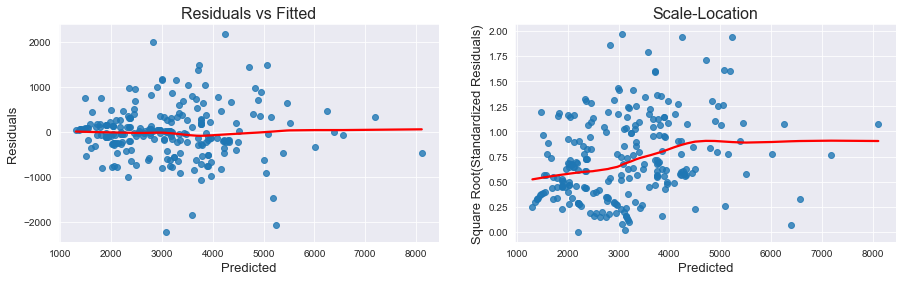

In [973]:
#Homoscedasticity-the variance of the error term must be the same across all levels of independent variables.
#This assumption can be tested by visual inspection of a standardized residual plot by the standardized regression 
#predicted value. Ideally, when the residuals are evenly scattered around the horizontal line, there is presence 
#of homoscedasticity; and when the residuals are not evenly scattered around the horizontal line and takes a various 
#shape like a bowtie, funnel shape, etc., then there is the presence of heteroscedasticity.
 
import statsmodels.stats.api as sms

def homoscedasticity_test(model):
    
    fitted_vals = model.predict()
    residuals = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal
    
    sns.set_style('darkgrid')
    
    
    fig, ax = plt.subplots(1,2,figsize=(15,4))

    sns.regplot(x=fitted_vals, y=residuals, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Residuals', fontsize=13)

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Square Root(Standardized Residuals)', fontsize=13)

      
homoscedasticity_test(lm_sm)
#both graphs show evenly spread residuals so homoscedasticity is present

C:\Users\v_v\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Jarque-Bera test ---- statistic: 76.1327, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9473, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5084, p-value: 0.0000
Anderson-Darling test ---- statistic: 3.8130, 5% critical value: 0.7740
If the returned Anderson Draling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


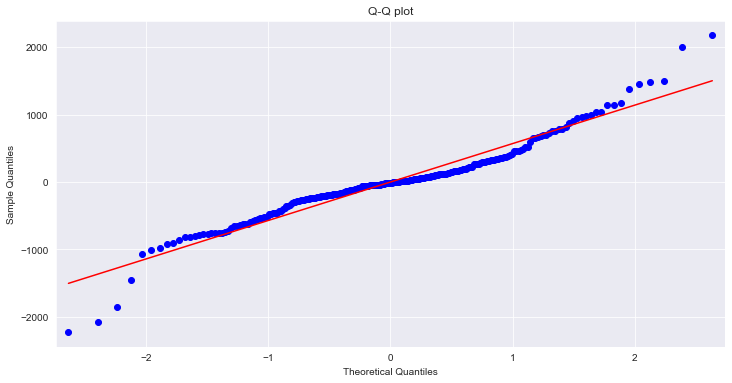

In [974]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');
    

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned Anderson Draling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(lm_sm)

#Q-Q plot shows residuals is mostly normal except at upper tail

#Since normality is not a strict assumption and close to normal distribution is fine, its safe to ignore the upper tail

#https://stats.stackexchange.com/questions/152674/why-is-the-normality-of-residuals-barely-important-at-all-for-the-purpose-of-e

<b> Normality of errors not satisifed as:
    1. Q-Q Plot shows deviation from normal distirbution esp at tails
    2. P-value in first 3 normality tests<0.05 and Anderson-Darling statistic>AD critical value, thus null hypo that 
    errors have normal dist is rejected


In [975]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

MAE: 453.9958947836192
MSE: 440765.4299797106
RMSE: 663.9016719211593


## 2)Algo-2= Fitting model using Random Forest Regressor

1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data
    * Scaling is not done in Random forest
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check **RSME** Score
7. Plot graph

In [918]:
## Not needed for any feature scaling for Decisison tree algorithms

In [879]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [880]:
y_pred = reg_rf.predict(X_test)

In [881]:
reg_rf.score(X_train, y_train)

0.9609374852884931

In [882]:
reg_rf.score(X_test, y_test)

0.7436442038194184

### Feature Importance

In [884]:
X=outlierremoved_catdummies_data.drop('Cost',axis=1)
y=outlierremoved_catdummies_data['Cost']

In [885]:
X.shape,y.shape

((297, 270), (297,))

In [886]:
#Feature Importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [887]:
from sklearn.ensemble import ExtraTreesRegressor
model= ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [888]:
#print(model.feature_importances_)
print(type(model.feature_importances_))
print(X.columns)
print(type(X.columns))

<class 'numpy.ndarray'>
Index(['Priority', 'Distance', 'Origin City_ANNISTON', 'Origin City_ARGO',
       'Origin City_BATON ROUGE', 'Origin City_BAYPORT', 'Origin City_BISHOP',
       'Origin City_BROWNSVILLE', 'Origin City_CHARLESTON',
       'Origin City_CHICAGO HEIGHTS',
       ...
       'Destination State_SC', 'Destination State_TN', 'Destination State_TX',
       'Destination State_UT', 'Destination State_VA', 'Destination State_WI',
       'Destination State_WV', 'Route Class_Blue', 'Route Class_Green',
       'Route Class_Red'],
      dtype='object', length=270)
<class 'pandas.core.indexes.base.Index'>


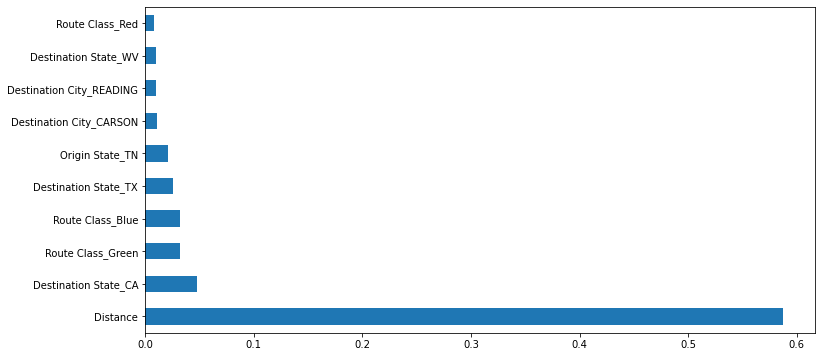

In [927]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [925]:
ok=feat_importances.nlargest(10)

In [926]:
ok ['Distance','Destination State_CA','Route Class_Green','Route Class_Blue','Destination State_TX','Origin State_TN','Destination City_CARSON','Destination City_READING','Destination State_WV','Route Class_Red']

Distance                    0.587231
Destination State_CA        0.047321
Route Class_Green           0.032466
Route Class_Blue            0.032020
Destination State_TX        0.025419
Origin State_TN             0.020627
Destination City_CARSON     0.010699
Destination City_READING    0.009970
Destination State_WV        0.009496
Route Class_Red             0.008540
dtype: float64

## Hyperparameter Tuning


* Choose following method for hyperparameter tuning
    1. **RandomizedSearchCV** --> Fast
    2. **GridSearchCV**
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

In [855]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [856]:
# Decision tree and Random forrest doesnot need standard scaling 
from sklearn.ensemble import RandomForestRegressor
#rf_random= RandomForestRegressor()

In [857]:
#Hyperparameters tuning using Gridsearchcv and 5old cross validation
import numpy as np
n_estimators= [int(x) for x in np.linspace(100,1200,num=12) ]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [858]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

 #Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [859]:
# Create the random grid using key value pair
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [860]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)#,scoring='neg_mean_squared_error'
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   1.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, verbose=2)

In [861]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [862]:
rf_random.score(X_train, y_train)

0.9011155065901856

In [863]:
rf_random.score(X_test,y_test)

0.7090051538433211

In [864]:
predictions=rf_random.predict(X_test)

C:\Users\v_v\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Cost', ylabel='Density'>

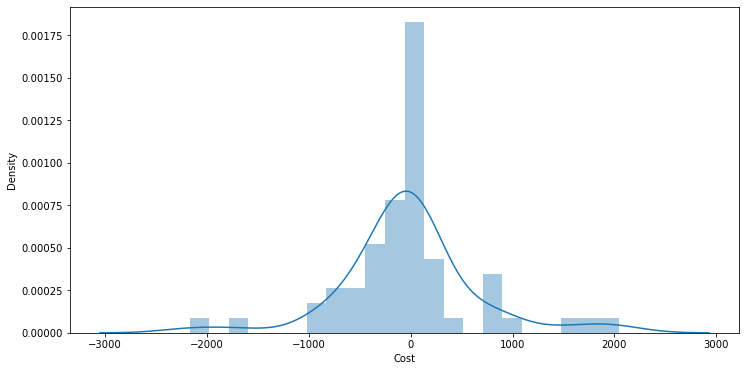

In [865]:
sns.distplot(y_test-predictions)
#Gausiian distributino graph:diff of MSE between actual and predicted is between -2 to 2

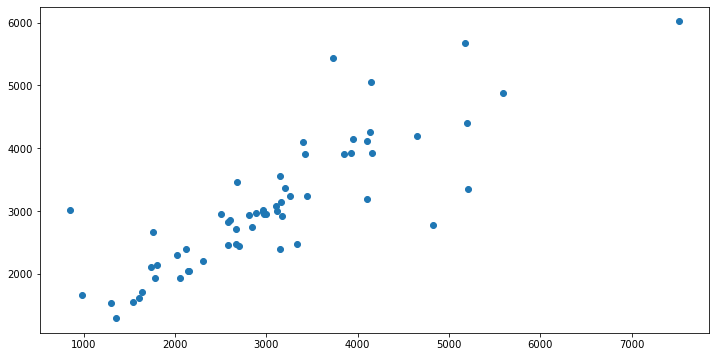

In [866]:
plt.scatter(y_test,predictions)

In [867]:
from sklearn import metrics

In [868]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 413.5778742404569
MSE: 435666.4013677085
RMSE: 660.0503021495472


import pickle
# open a file, where you want to store the data
file=open("kushwanthreandomforrestregressor.pkl","wb")
# dump information to that file
pickle.dump(rf_random,file)
!pip freeze requirements.txt  

model = open('flight_price_rf.pkl','rb')
forest = pickle.load(model)

y_prediction = forest.predict(X_test)
metrics.r2_score(y_test, y_prediction)